In [35]:
import pandas as pd
import numpy as np

In [36]:
# 당뇨병 데이터 불러오기
df = pd.read_csv('diabetes_data.csv')

In [37]:
# feature와 target 분리
target = df[['Diabetes']]
data = df.drop(columns=['Diabetes'])

In [38]:
# train_test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=33)

In [39]:
# Pipeline 을 위한 전처리 모듈 불러오기
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [40]:
x_train.head(3)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP
50498,13.0,0.0,1.0,1.0,32.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
44300,10.0,0.0,1.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,10.0,20.0,0.0,0.0,1.0
49497,8.0,1.0,1.0,1.0,35.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0


In [41]:
# 파이프라인
# 수로 된 열 선택
numeric_features = ['Age', 'BMI', 'MentHlth', 'PhysHlth']
numeric_transformer = StandardScaler()

# 수로 된 열 제외한 모든 라벨로 된 열 선택
categorical_features = list(x_train.columns)
categorical_features.remove('Age')
categorical_features.remove('BMI')
categorical_features.remove('MentHlth')
categorical_features.remove('PhysHlth')

categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

# 전처리 모델 생성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [42]:
# 파이프라인으로 전처리
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [43]:
# 파이프라인 학습
preprocessor_pipe.fit(x_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'BMI', 'MentHlth',
                                                   'PhysHlth']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'GenHlth', 'DiffWalk',
                                                   'Stroke', 'HighBP'])]))])

In [44]:
# 파이프라인 학습된 전처리로 변환
x_train = preprocessor_pipe.transform(x_train)
x_test = preprocessor_pipe.transform(x_test)

In [45]:
# 딥러닝 모듈 불러오기
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [46]:
# target 데이터 원핫인코딩
y_train = utils.to_categorical(y_train)

In [47]:
x_train.shape

(56553, 33)

In [48]:
# 순차적 모델 생성
model = models.Sequential()

# 열 31개
model.add(layers.Dense(input_dim=33, units=256, activation=None, kernel_initializer=initializers.he_normal()))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_normal())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_normal())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_normal())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5))

# 이진분류 도출
model.add(layers.Dense(units=2, activation='softmax'))

In [49]:
# 모델 컴파일
model.compile(optimizer=optimizers.Adam(0.01),
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [50]:
# 모델 학습
history = model.fit(x_train, y_train, batch_size=5700, epochs=30, validation_split=0.3)

Epoch 1/30
7/7 [==============================] - 2s 213ms/step - loss: 9.3009 - categorical_accuracy: 0.5837 - val_loss: 2.7201 - val_categorical_accuracy: 0.5462
Epoch 2/30
7/7 [==============================] - 2s 311ms/step - loss: 2.3253 - categorical_accuracy: 0.6742 - val_loss: 0.6938 - val_categorical_accuracy: 0.6395
Epoch 3/30
7/7 [==============================] - 2s 212ms/step - loss: 0.8172 - categorical_accuracy: 0.6316 - val_loss: 0.5740 - val_categorical_accuracy: 0.7171
Epoch 4/30
7/7 [==============================] - 2s 304ms/step - loss: 0.6395 - categorical_accuracy: 0.6756 - val_loss: 0.6009 - val_categorical_accuracy: 0.6722
Epoch 5/30
7/7 [==============================] - 2s 300ms/step - loss: 0.6011 - categorical_accuracy: 0.6946 - val_loss: 0.5404 - val_categorical_accuracy: 0.7273
Epoch 6/30
7/7 [==============================] - 2s 308ms/step - loss: 0.5825 - categorical_accuracy: 0.7122 - val_loss: 0.5360 - val_categorical_accuracy: 0.7275
Epoch 7/30
7/7 [

In [51]:
# 평가 모듈 불러오기
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [52]:
# test 예측
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [53]:
# 모델 평가
acc = accuracy_score(y_test, y_pred)
prs = precision_score(y_test, y_pred)
rc = recall_score(y_test, y_pred)
print('accuracy_score : ', acc)
print('precision_score : ', prs)
print('recall_score : ', rc)

accuracy_score :  0.7518212037626424
precision_score :  0.7184820978315684
recall_score :  0.8170609318996416


In [54]:
# 시각화 모듈 불러오기
import matplotlib.pyplot as plt

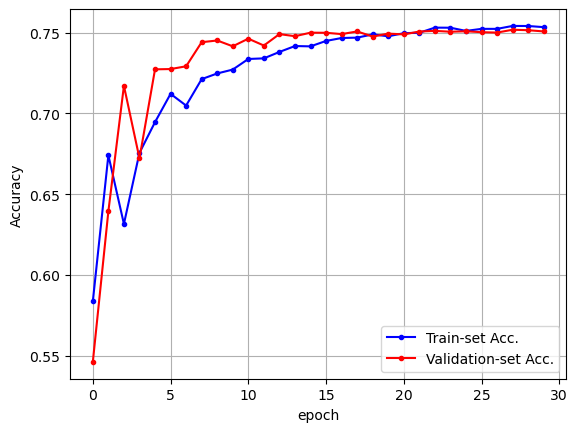

In [55]:
# train, validtion 정확도 시각화
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()